# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 18: Multi Assets Algorithmic Trading Backtesting with Vectorbt

## 1. Downloading the data:

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime

import vectorbt as vbt # version=0.23.0
from vectorbt.portfolio.nb import order_nb, sort_call_seq_nb
from vectorbt.portfolio.enums import SizeType, Direction

import warnings

warnings.filterwarnings("ignore")

# Date range
start = '2015-01-01'
end = '2021-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Close', slice(None))]
data.columns = assets

display(data.head())

[*********************100%***********************]  25 of 25 completed


,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,63.830002,129.949997,39.820751,59.509998,28.674999,23.629999,44.000000,88.339996,18.274296,45.664921,...,16.679764,68.150002,187.229996,42.700001,33.869999,75.330002,128.119995,42.169998,46.959999,28.290001
2015-01-05,59.910000,129.050003,38.832157,58.580002,27.980000,22.879999,43.330002,86.449997,17.970028,44.973824,...,16.483301,65.860001,188.110001,42.090000,33.549999,73.980003,126.360001,41.360001,46.570000,27.230000
2015-01-06,59.259998,127.529999,38.625748,58.480000,27.615000,22.370001,43.040001,85.730003,17.833788,44.481674,...,16.290766,65.949997,191.320007,42.310001,33.599998,73.970001,125.180000,41.180000,47.040001,26.190001
2015-01-07,58.599998,129.509995,38.810429,59.240002,27.590000,22.660000,44.939999,85.360001,18.042688,45.193718,...,16.565815,66.830002,195.240005,42.369999,33.169998,76.769997,128.929993,41.450001,46.189999,26.440001
2015-01-08,60.869999,131.800003,39.815319,60.720001,28.190001,23.200001,45.529999,86.489998,18.474113,46.062828,...,16.868368,67.709999,197.899994,43.150002,33.500000,77.129997,130.270004,43.320000,47.180000,26.809999


## 2 Building the Backtest Function with Backtrader 

### 2.1 Building Auxiliary Functions for Rebalancing

In [2]:
vbt.settings.returns['year_freq'] = '252 days'

num_tests = 2000
ann_factor = data.vbt.returns(freq='D').ann_factor

def pre_sim_func_nb(sc, every_nth):
    # Define rebalancing days
    sc.segment_mask[:, :] = False
    sc.segment_mask[every_nth::every_nth, :] = True
    return ()


def pre_segment_func_nb(sc, find_weights_nb, rm, history_len, ann_factor, num_tests, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = sc.close[:sc.i, sc.from_col:sc.to_col]
    else:
        # Look back at a fixed time period
        if sc.i - history_len <= 0:
            return (np.full(sc.group_len, np.nan),)  # insufficient data
        close = sc.close[sc.i - history_len:sc.i, sc.from_col:sc.to_col]
    
    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(sc, rm, close, num_tests)
    srb_sharpe[sc.i] = best_sharpe_ratio
        
    # Update valuation price and reorder orders
    size_type = np.full(sc.group_len, SizeType.TargetPercent)
    direction = np.full(sc.group_len, Direction.LongOnly)
    temp_float_arr = np.empty(sc.group_len, dtype=np.float_)
    for k in range(sc.group_len):
        col = sc.from_col + k
        sc.last_val_price[col] = sc.close[sc.i, col]
    sort_call_seq_nb(sc, weights, size_type, direction, temp_float_arr)
    
    return (weights,)


def order_func_nb(oc, weights):
    col_i = oc.call_seq_now[oc.call_idx]
    return order_nb(
        weights[col_i], 
        oc.close[oc.i, oc.col],
        size_type=SizeType.TargetPercent, 
    )

### 2.2 Building the Optimization Function

In [3]:
import riskfolio as rp

def opt_weights(sc, rm, close, num_tests):
    # Calculate expected returns and sample covariance matrix
    close = pd.DataFrame(close, columns=assets)
    returns = close.pct_change().dropna()

    # Building the portfolio object
    port = rp.Portfolio(returns=returns)
    # Calculating optimum portfolio

    # Select method and estimate input parameters:

    method_mu='hist' # Method to estimate expected returns based on historical data.
    method_cov='hist' # Method to estimate covariance matrix based on historical data.

    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

    # Estimate optimal portfolio:
    
    port.solvers = ['MOSEK']
    model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
    rm = rm # Risk measure used, this time will be variance
    obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True # Use historical scenarios for risk measures that depend on scenarios
    rf = 0 # Risk free rate
    l = 0 # Risk aversion factor, only useful when obj is 'Utility'

    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    weights = np.ravel(w.to_numpy())  
    shp = rp.Sharpe(w, port.mu, cov=port.cov, returns=returns, rm=rm, rf=0, alpha=0.05)

    return shp, weights

## 3 Building Strategies with Vectorbt

### 3.1 Optimizing Portfolios each Rebalancing Date

In [4]:
%%time

# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded returns.
# 'UCI': Ulcer Index of uncompounded returns.

rms = ["MV", "CVaR", "EVaR", "WR", "CDaR"]

sharpe = {}
portfolio = {}

for i in rms:
    sharpe[i] = np.full(data.shape[0], np.nan)

    # Run simulation with a custom order function (Numba should be disabled)
    portfolio[i] = vbt.Portfolio.from_order_func(
        data,
        order_func_nb,
        pre_sim_func_nb=pre_sim_func_nb,
        pre_sim_args=(30,),
        pre_segment_func_nb=pre_segment_func_nb,
        pre_segment_args=(opt_weights, i, 252*4, ann_factor, num_tests, sharpe[i]),
        cash_sharing=True, 
        group_by=True,
        use_numba=False,
    )

CPU times: user 7min 13s, sys: 13.7 s, total: 7min 26s
Wall time: 6min 10s


### 3.2 Plotting Portfolio Composition each Rebalancing Date

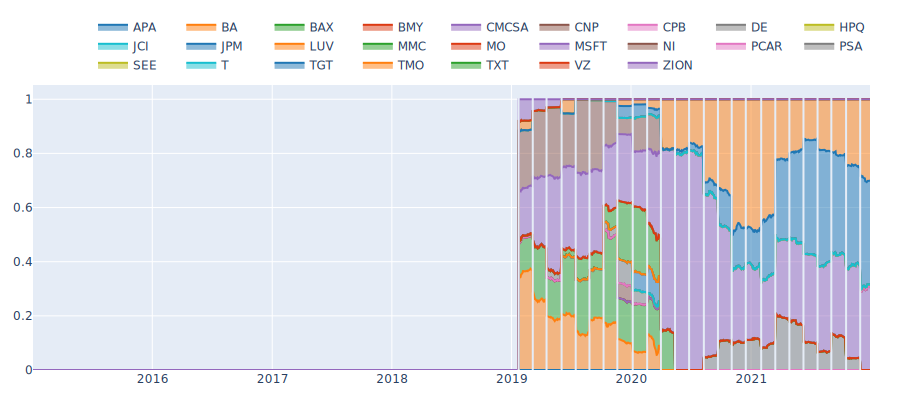

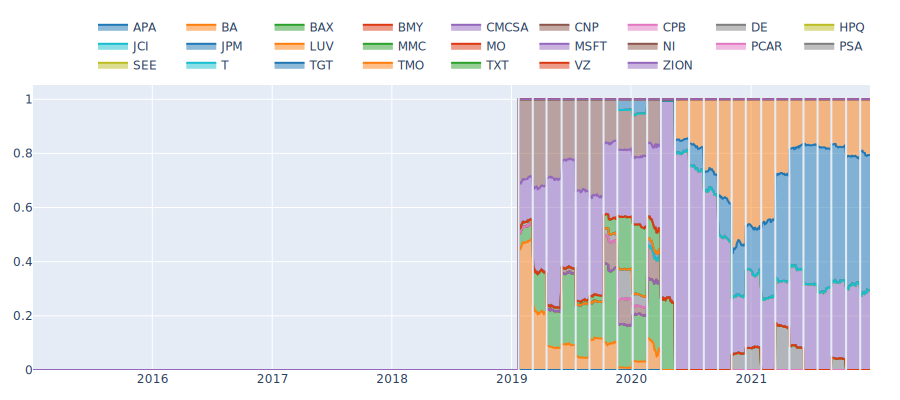

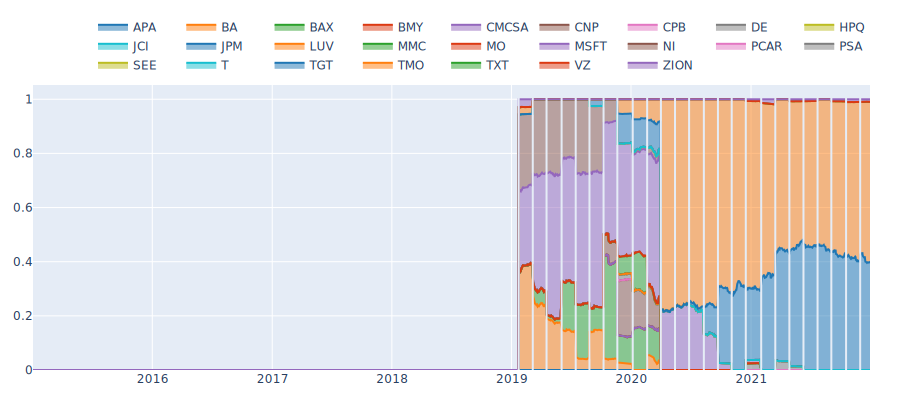

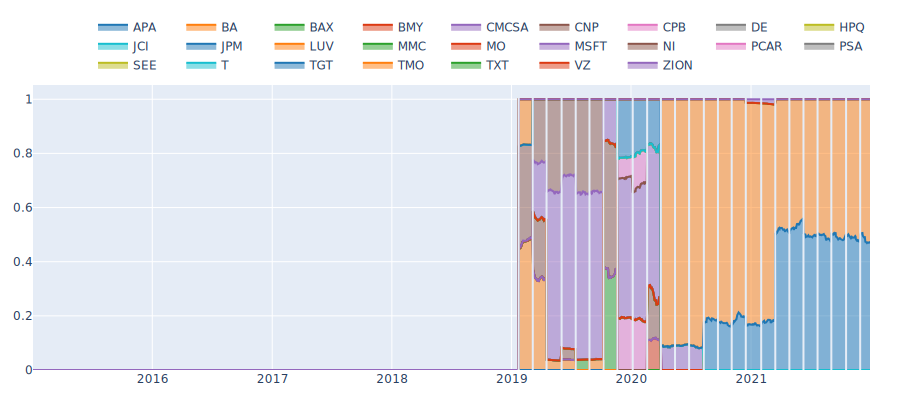

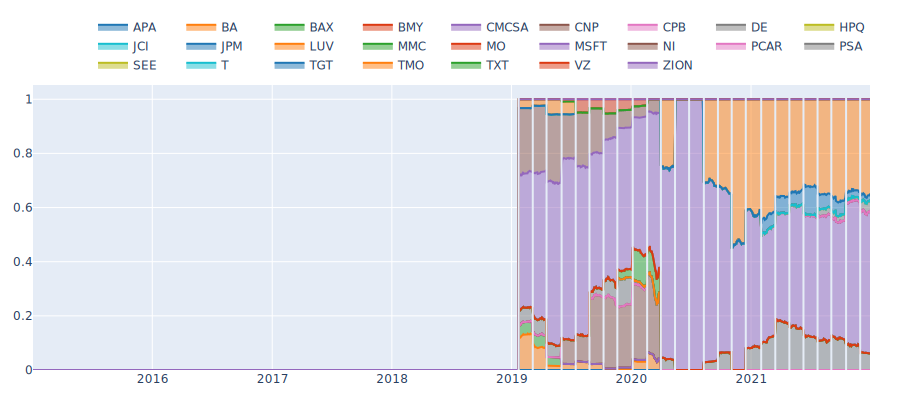

In [5]:
vbt.settings['plotting']['layout']['width'] = 900
vbt.settings['plotting']['layout']['height'] = 400

def plot_allocation(rb_pf):
    # Plot weights development of the portfolio
    rb_asset_value = rb_pf.asset_value(group_by=False)
    rb_value = rb_pf.value()
    rb_idxs = np.flatnonzero((rb_pf.asset_flow() != 0).any(axis=1))
    rb_dates = rb_pf.wrapper.index[rb_idxs]
    fig = (rb_asset_value.vbt / rb_value).vbt.plot(
        trace_names=assets,
        trace_kwargs=dict(
            stackgroup='one'
        )
    )
    for rb_date in rb_dates:
        fig.add_shape(
            dict(
                xref='x',
                yref='paper',
                x0=rb_date,
                x1=rb_date,
                y0=0,
                y1=1,
                line_color=fig.layout.template.layout.plot_bgcolor
            )
        )
    fig.show_svg()
    
for i in rms:
    plot_allocation(portfolio[i])

### 3.3 Plotting Portfolio Values

<AxesSubplot:>

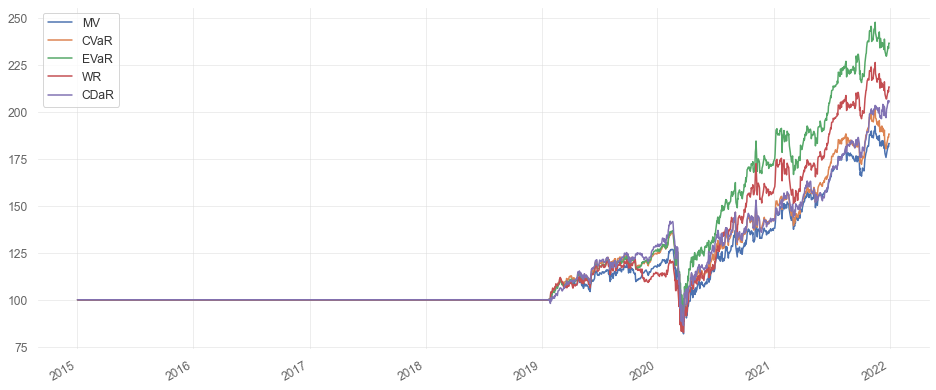

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,7))

values = pd.DataFrame([])
for i in rms:
    a = portfolio[i].value()
    values = pd.concat([values, a], axis=1)

values.columns = rms
values = pd.DataFrame(values)
values.plot(ax=ax)

### 3.4 Portfolio Stats

In [7]:
stats = pd.DataFrame([])
for i in rms:
    a = portfolio[i].stats()
    stats = pd.concat([stats, a], axis=1)

stats.columns = rms
display(stats)

,MV,CVaR,EVaR,WR,CDaR
Start,2015-01-02 00:00:00,2015-01-02 00:00:00,2015-01-02 00:00:00,2015-01-02 00:00:00,2015-01-02 00:00:00
End,2021-12-30 00:00:00,2021-12-30 00:00:00,2021-12-30 00:00:00,2021-12-30 00:00:00,2021-12-30 00:00:00
Period,1762,1762,1762,1762,1762
Start Value,100.0,100.0,100.0,100.0,100.0
End Value,183.297731,188.368812,236.761905,213.436048,206.023652
Total Return [%],83.297731,88.368812,136.761905,113.436048,106.023652
Benchmark Return [%],109.73352,109.73352,109.73352,109.73352,109.73352
Max Gross Exposure [%],100.0,100.0,100.0,100.0,100.0
Total Fees Paid,0.0,0.0,0.0,0.0,0.0
Max Drawdown [%],35.477423,36.162412,32.238102,32.104593,39.156973
